CohEx: Cohort-Level Exploration & Analysis

In [ ]:
"""
Classify cohorts based on cancer-type Z-scores.

Steps:
1. Define thresholds: >1.96 = Oncogene-like, < -1.96 = Tumor suppressor-like.
2. Identify cancer-type columns (exclude 'Gene', "Stouffer's Z", 'Group').
3. For each cohort, count cancer types above/below thresholds and assign class based on the higher count.
4. Store results in a DataFrame and summarize cohort counts by class.

Outputs:
- `cohort_classes`: cohort classification with counts of oncogene-like and tumor suppressor–like signals.
- `class_counts_all`: total number of cohorts per class.
"""

import pandas as pd
import os
import numpy as np

# loading the labels
labelsPath = "cohex_shap_labels.npy"
labels = np.load(labelsPath)

# loading the CSV (two levels up to cohex-main, then into scenario)
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
df = pd.read_csv(csvPath)

# ensuring that labels match rows
assert len(labels) == len(df), "Number of labels and rows in CSV do not match!"

# adding labels to DataFrame
df['Group'] = labels

# defining significance thresholds
upperCut = 1.96   # oncogene-like cutoff
lowerCut = -1.96  # tumor suppressor-like cutoff

# identifying cancer type columns
cancerCols = [c for c in df.columns if c not in ['Gene', "Stouffer's Z",'Group']]

# classification function using all cancer-type Z scores (count based)
def classifyAllCohort(group_df):
    values = group_df[cancerCols].values.flatten()
    numOnco = (values > upperCut).sum()
    numSuppressor = (values < lowerCut).sum()

    if numOnco >= numSuppressor:
        classification = "Oncogene-like"
    else:
        classification = "Tumor suppressor-like"

    return {"Class_all_cancers": classification,
            "numOnco": numOnco,
            "numSuppressor": numSuppressor}

# applying classification to each cohort
classResults = {}
for g, group_df in df.groupby("Group"):
    classResults[g] = classifyAllCohort(group_df)

# turning into dataframe
cohortClasses = pd.DataFrame.from_dict(classResults, orient="index")

# counting cohorts by class
classCountsAll = cohortClasses["Class_all_cancers"].value_counts()

print("\n Cohort classification with counts:")
print(cohortClasses)

print("\n Count of cohorts by classification:")
print(classCountsAll)



 Cohort classification with counts:
        Class_all_cancers  numOnco  numSuppressor
0   Tumor suppressor-like       21             97
1           Oncogene-like      113             72
2           Oncogene-like      158            100
3           Oncogene-like      259             84
4           Oncogene-like      232             80
5   Tumor suppressor-like       66            131
6   Tumor suppressor-like       43            102
7           Oncogene-like      199             11
8           Oncogene-like      245            114
9   Tumor suppressor-like       67            143
10  Tumor suppressor-like       56            218
11  Tumor suppressor-like      146            148

 Count of cohorts by classification:
Class_all_cancers
Tumor suppressor-like    6
Oncogene-like            6
Name: count, dtype: int64


Cohort-level average Stouffer's Z-score with classification:
       mean_Stouffer_Z                  Class
Group                                        
0            -2.063885  Tumor suppressor-like
1             0.640845                Neutral
2             0.463434                Neutral
3             1.986834          Oncogene-like
4             1.766728                Neutral
5            -2.107016  Tumor suppressor-like
6            -0.288010                Neutral
7             4.521813          Oncogene-like
8             1.549567                Neutral
9            -1.761513                Neutral
10           -1.990857  Tumor suppressor-like
11           -0.381867                Neutral


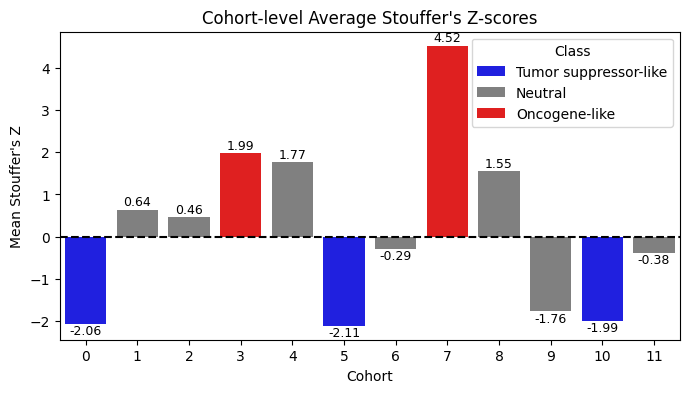

In [22]:
"""
Analyse and visualise cohort-level Stouffer's Z-scores.

Steps:
1. Compute mean Stouffer's Z per cohort and rename as 'mean_Stouffer_Z'.
2. Classify cohorts using ±1.96 thresholds:
   - "Oncogene-like" if >1.96
   - "Tumor suppressor-like" if <-1.96
   - "Neutral" otherwise
3. Plot a bar chart of mean Z-scores, color-coded by class (red, blue, grey).
4. Annotate bars with mean Z-score values above or below the bars.

This visualisation helps quickly identify cohorts with strong oncogene-like 
or tumor suppressor-like signals and compare their relative strengths.
"""


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# computing cohort-level average Stouffer's Z-score
cohortProfiles = df.groupby('Group')["Stouffer's Z"].mean().to_frame()
cohortProfiles.rename(columns={"Stouffer's Z": "mean_Stouffer_Z"}, inplace=True)

# adding classification based on thresholds from paper
def classifyCohort(z):
    if z > 1.96:
        return "Oncogene-like"
    elif z < -1.96:
        return "Tumor suppressor-like"
    else:
        return "Neutral"

cohortProfiles['Class'] = cohortProfiles['mean_Stouffer_Z'].apply(classifyCohort)

print("Cohort-level average Stouffer's Z-score with classification:")
print(cohortProfiles)

# barplots showing cohort-level Z and classification
plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    x=cohortProfiles.index, 
    y='mean_Stouffer_Z', 
    hue='Class', 
    data=cohortProfiles, 
    dodge=False,
    palette={'Oncogene-like':'red','Tumor suppressor-like':'blue','Neutral':'grey'}
)
plt.axhline(0, color='black', linestyle='--')
plt.title("Cohort-level Average Stouffer's Z-scores")
plt.ylabel("Mean Stouffer's Z")
plt.xlabel("Cohort")
plt.legend(title='Class')

# adding value labels on top/bottom of bars
for idx, row in cohortProfiles.iterrows():
    z = row['mean_Stouffer_Z']
    if z >= 0:
        va = 'bottom'  # label above bar
        offset = 0.02
    else:
        va = 'top'     # label below bar
        offset = -0.02
    barplot.text(idx, z + offset, f"{z:.2f}", ha='center', va=va, fontsize=9)

plt.show()


In [ ]:
"""
Analyse cohort-level Stouffer's Z-scores to identify top genes and visualise them.

Steps:
1. Compute cohort profiles:
   - Calculate mean Stouffer's Z per cohort.
   - Classify as "Oncogene-like" (>1.96), "Tumor suppressor–like" (<-1.96), or "Neutral".

2. Select top genes per cohort:
   - For non-neutral cohorts, pick top N genes with highest (oncogene-like) or lowest 
     (tumor suppressor–like) Z-scores.
   - Create a summary dataframe with top genes, cohort class and mean Z.

3. Visualise as table:
   - Save the top genes table as a PNG image.
   - Rows color-coded by class (red = oncogene-like, blue = tumor suppressor–like, grey = neutral).
"""




import pandas as pd
import matplotlib.pyplot as plt

# computing cohort-level average Stouffer's Z and classify
def classifyCohort(z):
    """Classify cohorts based on Stouffer's Z thresholds."""
    if z > 1.96:
        return "Oncogene-like"
    elif z < -1.96:
        return "Tumor suppressor–like"
    else:
        return "Neutral"

def computeCohortProfiles(df):
    """Compute mean Z per cohort and assign class."""
    cohortProfiles = df.groupby('Group')["Stouffer's Z"].mean().to_frame()
    cohortProfiles.rename(columns={"Stouffer's Z": "mean_Stouffer_Z"}, inplace=True)
    cohortProfiles['Class'] = cohortProfiles['mean_Stouffer_Z'].apply(classifyCohort)
    return cohortProfiles

# getting top N relevant genes per cohort
def getTopGenesTable(df, cohortProfiles, topN=5):
    """
    Get top N relevant genes per cohort based on classification.
    Returns a DataFrame ready for table display.
    """
    relevantGenes = {}

    for i, (cohort, row) in enumerate(cohortProfiles.iterrows(), start=1):
        cohortClass = row['Class']
        meanZ = row['mean_Stouffer_Z']

        if cohortClass == "Neutral":
            continue  # skipping neutral cohorts

        cohortDf = df[df['Group'] == cohort]

        if cohortClass == "Oncogene-like":
            topGenes = cohortDf.nlargest(topN, "Stouffer's Z")["Gene"].tolist()
        elif cohortClass == "Tumor suppressor–like":
            topGenes = cohortDf.nsmallest(topN, "Stouffer's Z")["Gene"].tolist()

        relevantGenes[f"Cohort {i}"] = {
            **{f"Top_{j+1}": gene for j, gene in enumerate(topGenes)},
            "Class": cohortClass,
            "Mean_Stouffer_Z": meanZ
        }

    topGenesDf = pd.DataFrame.from_dict(relevantGenes, orient='index')
    return topGenesDf

# saving table as png image
def saveTopGenesTableImage(topGenesDf, filename="topGenesTable.png"):
    """Save the top genes DataFrame as a PNG table image with legend."""
    fig, ax = plt.subplots(figsize=(max(8, topGenesDf.shape[1]), max(4, topGenesDf.shape[0]*0.6)))
    ax.axis('off')  # Hide axes

    # colour coding by Class
    colors = []
    for cls in topGenesDf['Class']:
        if cls == "Oncogene-like":
            colors.append('lightcoral')
        elif cls == "Tumor suppressor–like":
            colors.append('lightblue')
        else:
            colors.append('lightgrey')

    table = ax.table(
        cellText=topGenesDf.values,
        colLabels=topGenesDf.columns,
        rowLabels=topGenesDf.index,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )

    # applying row colors
    for i, color in enumerate(colors):
        for j in range(len(topGenesDf.columns)):
            table[(i+1, j)].set_facecolor(color)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(topGenesDf.columns))))

    # adding legend on top right
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightcoral', edgecolor='k', label='Oncogene-like'),
        Patch(facecolor='lightblue', edgecolor='k', label='Tumor suppressor–like'),
        Patch(facecolor='lightgrey', edgecolor='k', label='Neutral')
    ]
    fig.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=10)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Table image saved as '{filename}'")


# computing cohort profiles and getting top genes table
cohortProfiles = computeCohortProfiles(df)
topGenesDf = getTopGenesTable(df, cohortProfiles, topN=5)
print(topGenesDf)

# saving results as png
saveTopGenesTableImage(topGenesDf, filename="topGenesPerCohort.png")


            Top_1   Top_2   Top_3  Top_4  Top_5                  Class  \
Cohort 1     GBE1   KIF15  EXOSC7  RPL14   MLH1  Tumor suppressor–like   
Cohort 4     BTG2   CENPF   WDR43  ACTR3  PPM1G          Oncogene-like   
Cohort 6   CDKN2A    LSM7   HMGB2  SAP30   LDLR  Tumor suppressor–like   
Cohort 8    MRPL9  ANP32E   UBE2T  UCHL5   ILF2          Oncogene-like   
Cohort 11  CHAF1A   SPC24    PPAN  DNMT1   ILF3  Tumor suppressor–like   

           Mean_Stouffer_Z  
Cohort 1         -2.063885  
Cohort 4          1.986834  
Cohort 6         -2.107016  
Cohort 8          4.521813  
Cohort 11        -1.990857  
Table image saved as 'topGenesPerCohort.png'


C:\Users\Taveer Abdullah\AppData\Local\Temp\ipykernel_12612\321573814.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  highlightedCells = cohortProfiles.applymap(lambda x: x if abs(x) >= thresholdCut else 0)


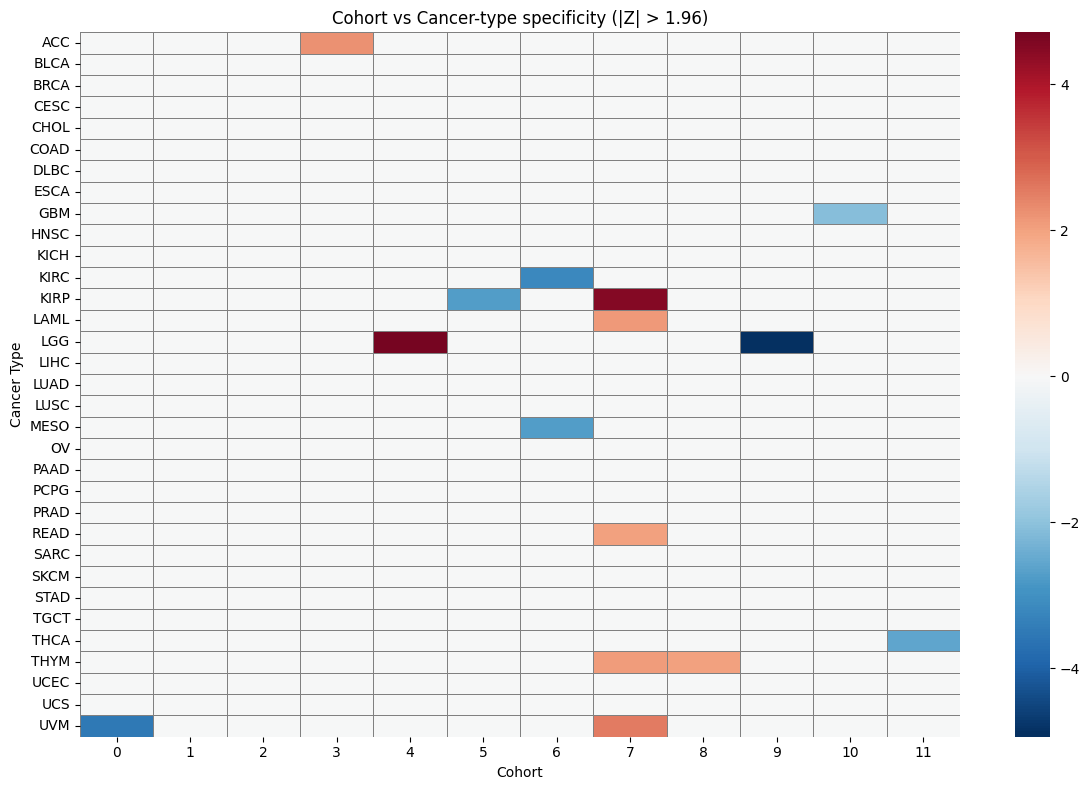

In [ ]:
"""
This script generates a heatmap to visualise cancer-type specificity across different cohorts.

Steps:
1. Group the dataframe by 'Group' (cohorts) and computes mean Z-scores for numeric columns.
2. Drop the 'Stouffer's Z' column to focus only on cancer-related features.
3. Apply a threshold to highlight strong signals (absolute Z-score >= 1.96) while keeping the sign:
   - Positive Z (red) indicates strong positive association with a cancer.
   - Negative Z (blue) indicates strong negative association.
   - Small or insignificant values appear white.
4. Plot a transposed heatmap so that rows are cancer types and columns are cohorts.

Interpretation:
- Cohorts with strong colors in only a few rows are cancer-type specific.
- Cohorts with strong colors across many rows are pan-cancer drivers.
- The intensity and sign of the colors provide information about the strength and direction of association.
"""

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# computing mean Z-scores per cohort
cohortProfiles = df.groupby('Group').mean(numeric_only=True)

# dropping 'Stouffer's Z' column if it exists
if "Stouffer's Z" in cohortProfiles.columns:
    cohortProfiles = cohortProfiles.drop(columns=["Stouffer's Z"])

# focuing only on strong signals (|Z| > 1.96)
thresholdCut = 1.96
highlightedCells = cohortProfiles.applymap(lambda x: x if abs(x) >= thresholdCut else 0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(highlightedCells.T, cmap="RdBu_r", center=0, linewidths=0.5, linecolor='gray')
plt.title('Cohort vs Cancer-type specificity (|Z| > {})'.format(thresholdCut))
plt.xlabel('Cohort')
plt.ylabel('Cancer Type')
plt.tight_layout()
plt.show()


Comparative Analysis: CohEx vs. KMeans (CohEx Perspective) 

In [25]:
import numpy as np
import pandas as pd
import os

# loading the labels
labelsPath = "cohex_shap_labels.npy"
labels = np.load(labelsPath)

# loading the CSV (two levels up to cohex-main, then into scenario)
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
df = pd.read_csv(csvPath)

# ensuring that labels match rows
assert len(labels) == len(df), "Number of labels and rows in CSV do not match!"

# adding labels to DataFrame
df['Group'] = labels

# grouping by label 
grouped = df.groupby('Group')

# printing summary count per group
summary = df['Group'].value_counts().sort_index()
print("\nSummary count per group:")
print(summary)



Summary count per group:
Group
0     23
1     53
2     78
3     74
4     69
5     42
6     29
7     33
8     95
9     53
10    51
11    55
Name: count, dtype: int64


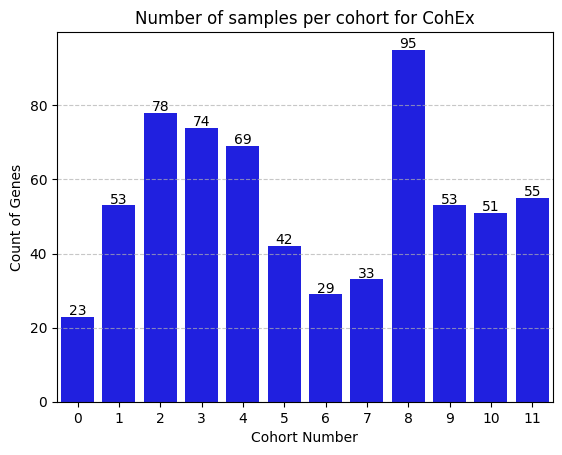

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating countplot with a single color (blue)
ax = sns.countplot(data=df, x='Group', color='blue')

# adding counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.5,  # slightly above the bar
        s=int(height),
        ha='center'
    )

# adding labels and title on the plot
plt.xlabel('Cohort Number')
plt.ylabel('Count of Genes')
plt.title('Number of samples per cohort for CohEx')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


CSV shape: (655, 35)
CSV columns: ['Gene', 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM', "Stouffer's Z"]
Number of feature columns: 33
NPY data shape: (12, 33)


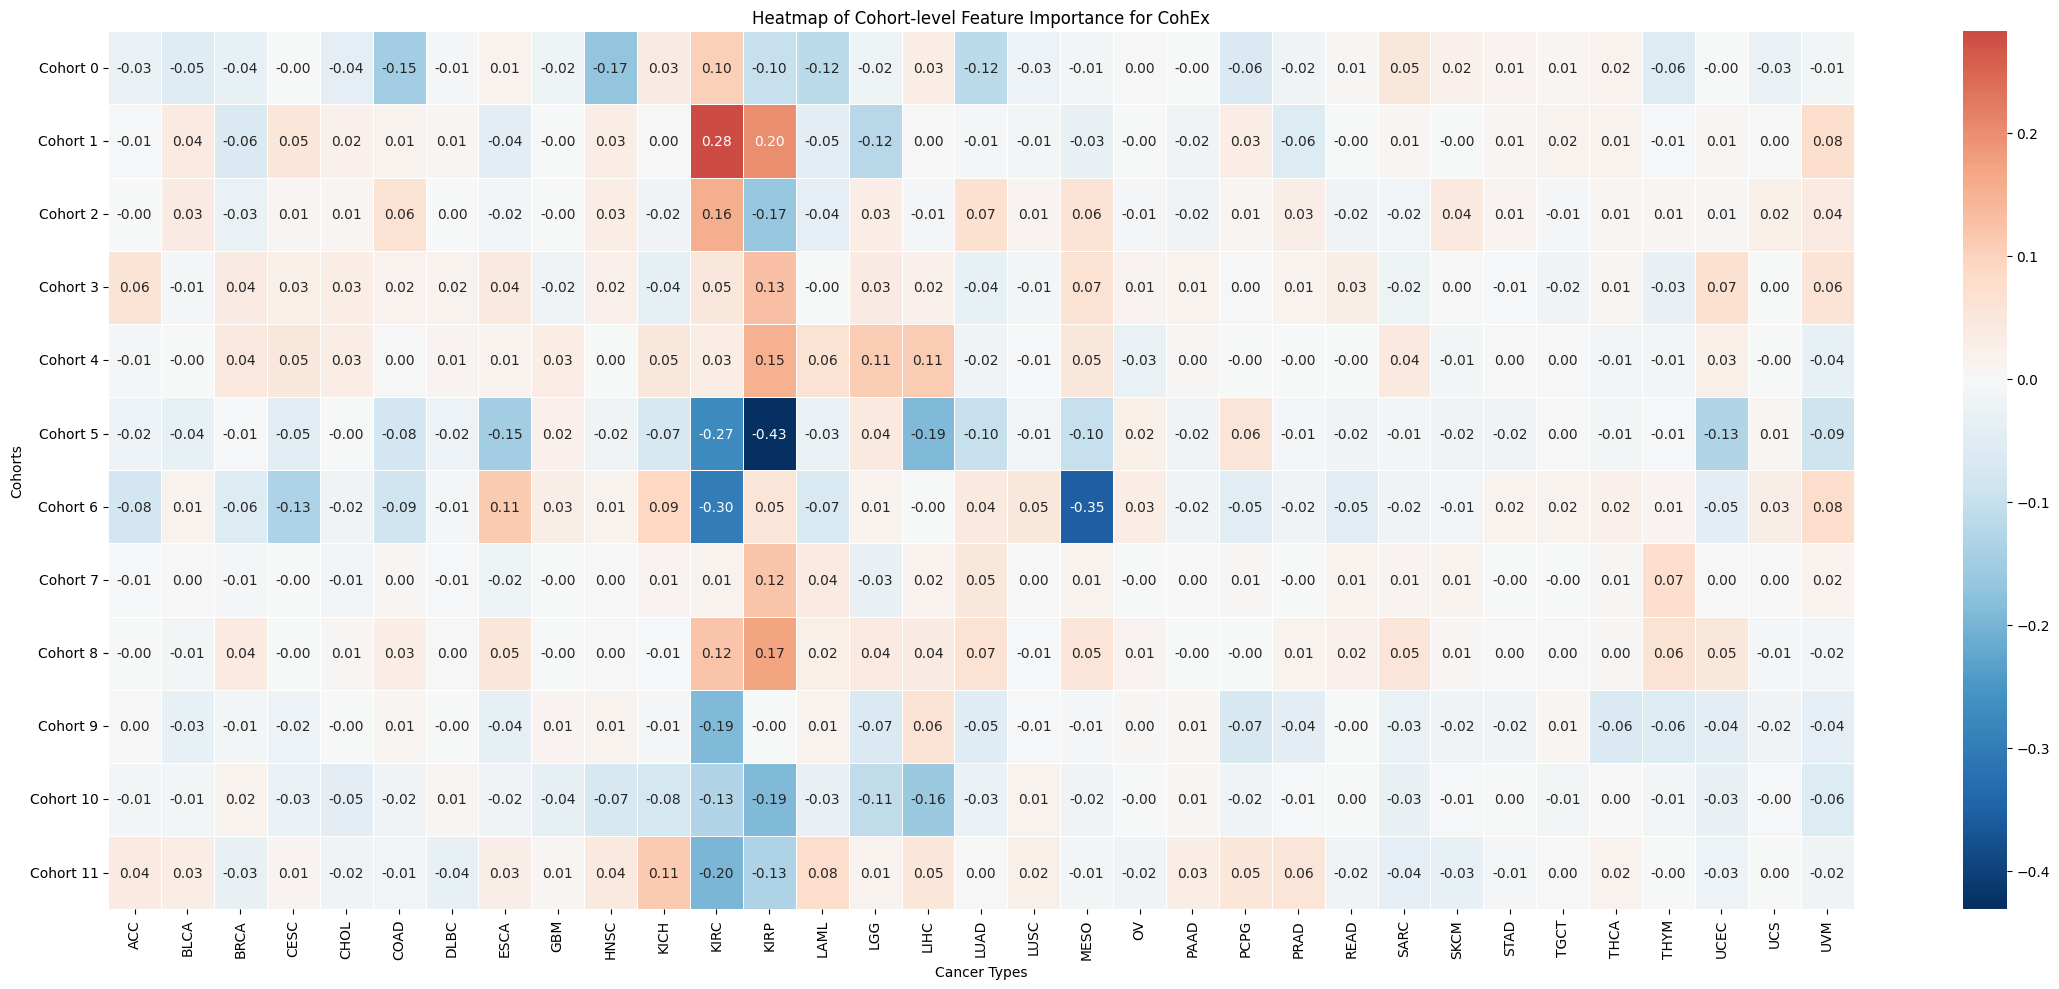

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# paths to files
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
npyPath = "cohex_shap_importance.npy"

# loading CSV for column names
dfCsv = pd.read_csv(csvPath)
print("CSV shape:", dfCsv.shape)
print("CSV columns:", dfCsv.columns.tolist())

# excluding first and last columns ('Gene' and "Stouffer's Z")
featureCols = dfCsv.columns[1:-1]
print("Number of feature columns:", len(featureCols))

# loading the .npy data
data = np.load(npyPath)
print("NPY data shape:", data.shape)

# making sure number of columns matches
if data.shape[1] != len(featureCols):
    raise ValueError("Number of columns in .npy does not match feature columns!")

# defining cohort labels
cohortLabels = [f"Cohort {i}" for i in range(data.shape[0])]

# creating the heatmap with annotations
figWidth = len(featureCols) * 0.7  
figHeight = 10  

plt.figure(figsize=(figWidth, figHeight))
sns.heatmap(
    data,
    xticklabels=featureCols,
    yticklabels=cohortLabels,
    cmap="RdBu_r",
    center=0,
    annot=True,          
    fmt=".2f",          
    linewidths=0.5       
)
plt.title("Heatmap of Cohort-level Feature Importance for CohEx")
plt.xlabel("Cancer Types")
plt.ylabel("Cohorts")
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()


CSV shape: (655, 35)
CSV columns: ['Gene', 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM', "Stouffer's Z"]
Number of feature columns: 33
Centroids shape: (12, 33)


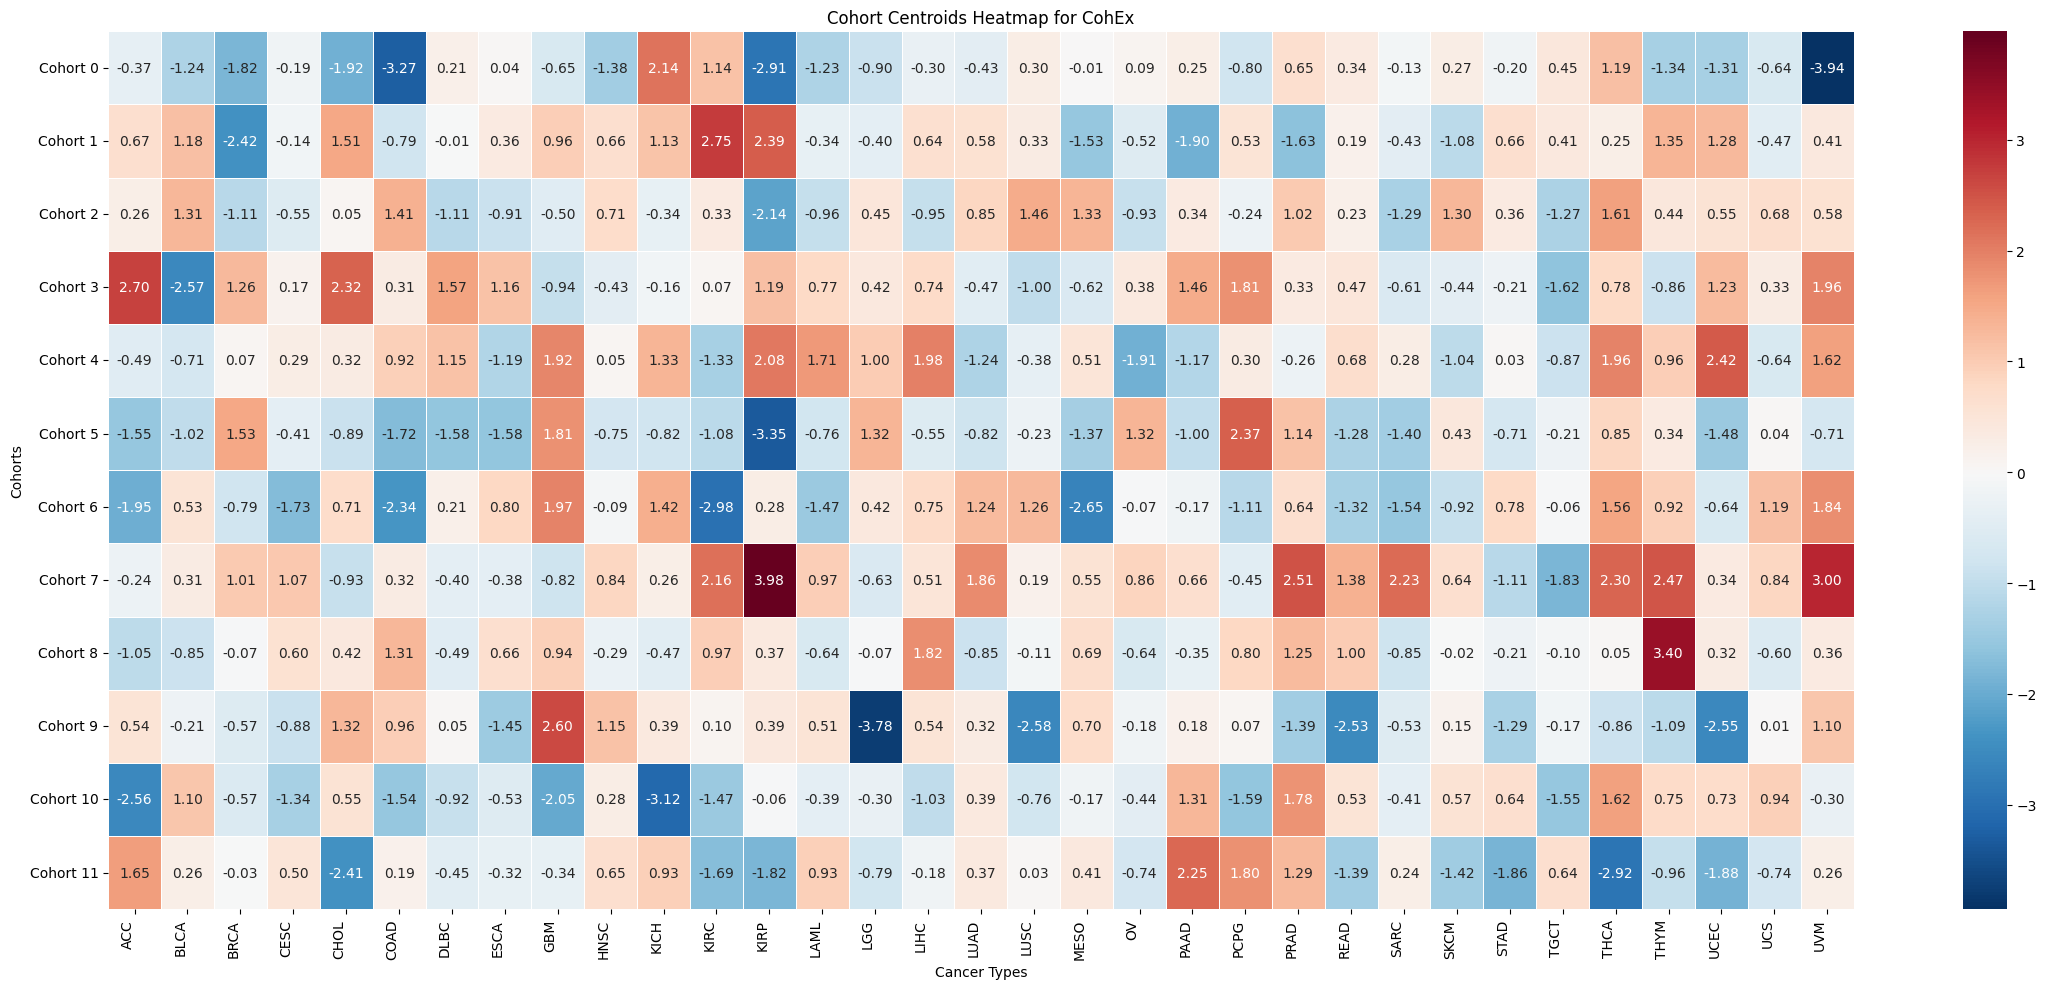

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# paths to files
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
npyPath = "cohex_shap_centroids.npy"

# loading CSV for column names
dfCsv = pd.read_csv(csvPath)
print("CSV shape:", dfCsv.shape)
print("CSV columns:", dfCsv.columns.tolist())

# excluding first and last columns ('Gene' and "Stouffer's Z")
featureCols = dfCsv.columns[1:-1]
print("Number of feature columns:", len(featureCols))

# loading the centroids from .npy file
centroids = np.load(npyPath)
print("Centroids shape:", centroids.shape)

# making sure number of columns matches
if centroids.shape[1] != len(featureCols):
    raise ValueError("Number of columns in .npy does not match feature columns!")

# defining cohort labels
cohortLabels = [f"Cohort {i}" for i in range(centroids.shape[0])]

# creating the heatmap with annotations
figWidth = len(featureCols) * 0.7  
figHeight = 10 

plt.figure(figsize=(figWidth, figHeight))
sns.heatmap(
    centroids,
    xticklabels=featureCols,
    yticklabels=cohortLabels,
    cmap="RdBu_r",
    center=0,
    annot=True,          
    fmt=".2f",          
    linewidths=0.5       
)

plt.xticks(rotation=90, ha="right")
plt.ylabel("Cohorts")
plt.xlabel("Cancer Types")
plt.title("Cohort Centroids Heatmap for CohEx")
plt.tight_layout()
plt.show()


In [ ]:

# computing distances from each centroid to all samples
from scipy.spatial.distance import cdist

# finding the closest sample in the dataset to each centroid
closestIndices = np.argmin(cdist(centroids, dfCsv[featureCols].values), axis=1)

# getting corresponding sample names 
closestSamples = dfCsv.iloc[closestIndices]['Gene'].values

# print results
for i, sample in enumerate(closestSamples):
    print(f"Cohort {i} centroid corresponds to sample: {sample}")



Cohort 0 centroid corresponds to sample: KIF15
Cohort 1 centroid corresponds to sample: TK1
Cohort 2 centroid corresponds to sample: DKC1
Cohort 3 centroid corresponds to sample: HK2
Cohort 4 centroid corresponds to sample: TENT4A
Cohort 5 centroid corresponds to sample: USO1
Cohort 6 centroid corresponds to sample: HSPA9
Cohort 7 centroid corresponds to sample: DSCC1
Cohort 8 centroid corresponds to sample: SLC38A1
Cohort 9 centroid corresponds to sample: CENPM
Cohort 10 centroid corresponds to sample: ALDOA
Cohort 11 centroid corresponds to sample: HMBS


C:\Users\Taveer Abdullah\AppData\Local\Temp\ipykernel_11604\3628436411.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1')


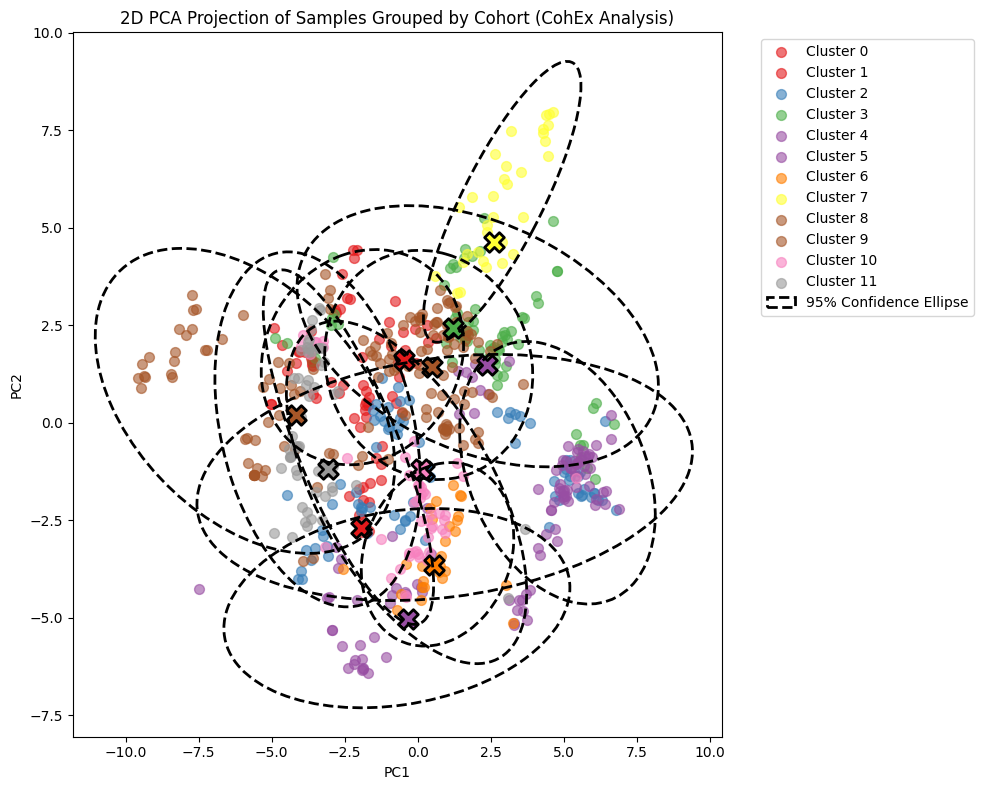

In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from scipy.stats import chi2

# loading the data
labels = np.load("cohex_shap_labels.npy")             
centroids = np.load("cohex_shap_centroids.npy")       

# feature matrix
dfCsv = pd.read_csv("../../scenario/Multivariate_CNA_filtered_by_hallmark.csv")
featureCols = dfCsv.columns[1:-1]
X = dfCsv[featureCols].values

# reducing to 2D
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)
centroids2d = pca.transform(centroids)

# plotting arguments
cmap = cm.get_cmap('Set1')  
uniqueLabels = np.unique(labels)
plt.figure(figsize=(10,8))

# plotting the samples
for i in uniqueLabels:
    cluster_points = X2d[labels == i]
    plt.scatter(cluster_points[:,0], cluster_points[:,1],
                color=cmap(i / len(uniqueLabels)), alpha=0.6, s=50, label=f"Cluster {i}")

# plotting centroids with same color as cluster
for i, centroid in enumerate(centroids2d):
    plt.scatter(centroid[0], centroid[1],
                color=cmap(i / len(uniqueLabels)), s=200, marker='X', edgecolor='black', linewidth=2)

# circling each cluster with 95% confidence ellipse
added_ci_label = False
for i in uniqueLabels:
    cluster_points = X2d[labels == i]
    mean = cluster_points.mean(axis=0)
    cov = np.cov(cluster_points, rowvar=False)

    # eigen-decomposition for orientation & axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # angle of ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    # chi-square scaling factor for 95% confidence in 2D
    chi2_val = chi2.ppf(0.95, df=2)
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    ellipse = Ellipse(
        mean, width, height, angle=angle,
        edgecolor='black', facecolor='none', lw=2, linestyle='--',
        label="95% Confidence Ellipse" if not added_ci_label else None
    )
    plt.gca().add_patch(ellipse)
    added_ci_label = True  

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Samples Grouped by Cohort (CohEx Analysis)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Comparative Analysis: CohEx vs. KMeans (KMeans Perspective) 

In [31]:
import numpy as np
import pandas as pd
import os

# loading the labels
labelsPath = "kmeans_by_feature_shap_labels.npy"
labels = np.load(labelsPath)

# laoding the CSV (two levels up to cohex-main, then into scenario)
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
df = pd.read_csv(csvPath)

# ensuring labels match rows
assert len(labels) == len(df), "Number of labels and rows in CSV do not match!"

# adding labels to DataFrame
df['Group'] = labels

# griuping by label and print
grouped = df.groupby('Group')

# summary count per group
summary = df['Group'].value_counts().sort_index()
print("\nSummary count per group:")
print(summary)



Summary count per group:
Group
0     45
1     53
2     40
3     88
4     37
5     69
6     42
7     52
8     60
9     50
10    75
11    44
Name: count, dtype: int64


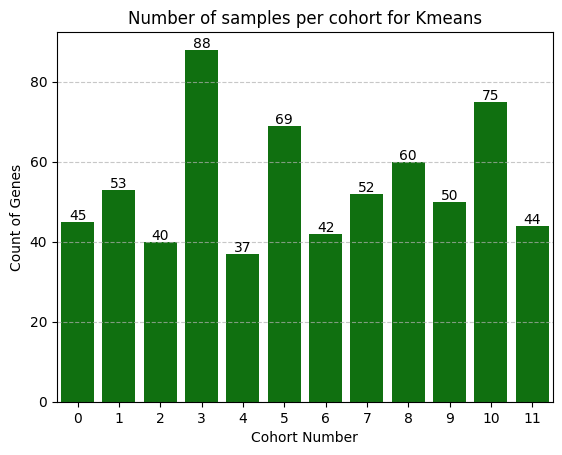

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# craeting countplot with a single color (green)
ax = sns.countplot(data=df, x='Group', color='green')

# adding counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.5,  
        s=int(height),
        ha='center'
    )

# adding labels and title
plt.xlabel('Cohort Number')
plt.ylabel('Count of Genes')
plt.title('Number of samples per cohort for Kmeans')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


CSV shape: (655, 35)
CSV columns: ['Gene', 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM', "Stouffer's Z"]
Number of feature columns: 33
NPY data shape: (12, 33)


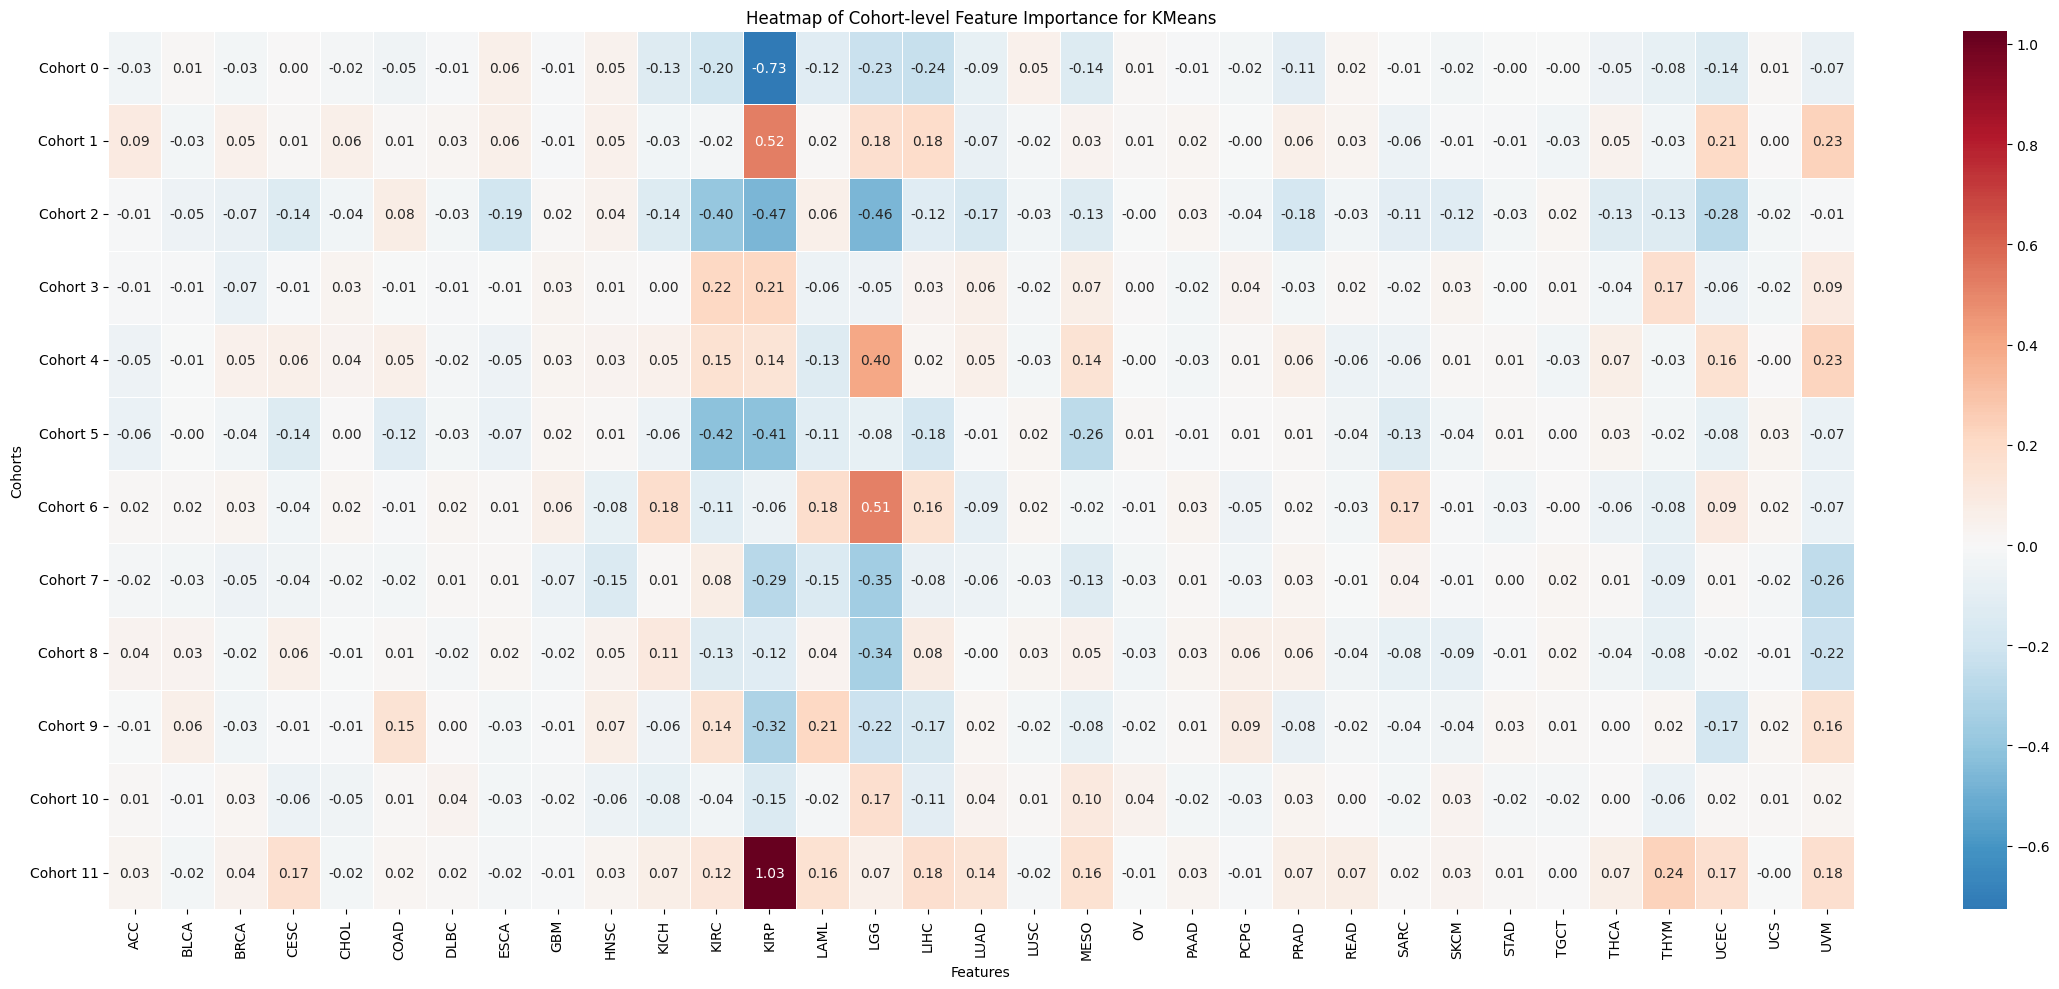

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# paths to files
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
npyPath = "kmeans_by_feature_shap_importance.npy"

# loading CSV for column names
dfCsv = pd.read_csv(csvPath)
print("CSV shape:", dfCsv.shape)
print("CSV columns:", dfCsv.columns.tolist())

# excluding first and last columns ('Gene' and "Stouffer's Z")
featureCols = dfCsv.columns[1:-1]
print("Number of feature columns:", len(featureCols))

# laoding the .npy data
data = np.load(npyPath)
print("NPY data shape:", data.shape)

# making sure number of columns matches
if data.shape[1] != len(featureCols):
    raise ValueError("Number of columns in .npy does not match feature columns!")

# defining cohort labels
cohortLabels = [f"Cohort {i}" for i in range(data.shape[0])]

# creating the heatmap with annotations
figWidth = len(featureCols) * 0.7  
figHeight = 10  

plt.figure(figsize=(figWidth, figHeight))
sns.heatmap(
    data,
    xticklabels=featureCols,
    yticklabels=cohortLabels,
    cmap="RdBu_r",
    center=0,
    annot=True,          
    fmt=".2f",          
    linewidths=0.5       
)
plt.title("Heatmap of Cohort-level Feature Importance for KMeans")
plt.xlabel("Features")
plt.ylabel("Cohorts")
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


CSV shape: (655, 35)
CSV columns: ['Gene', 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM', "Stouffer's Z"]
Number of feature columns: 33
Centroids shape: (12, 33)


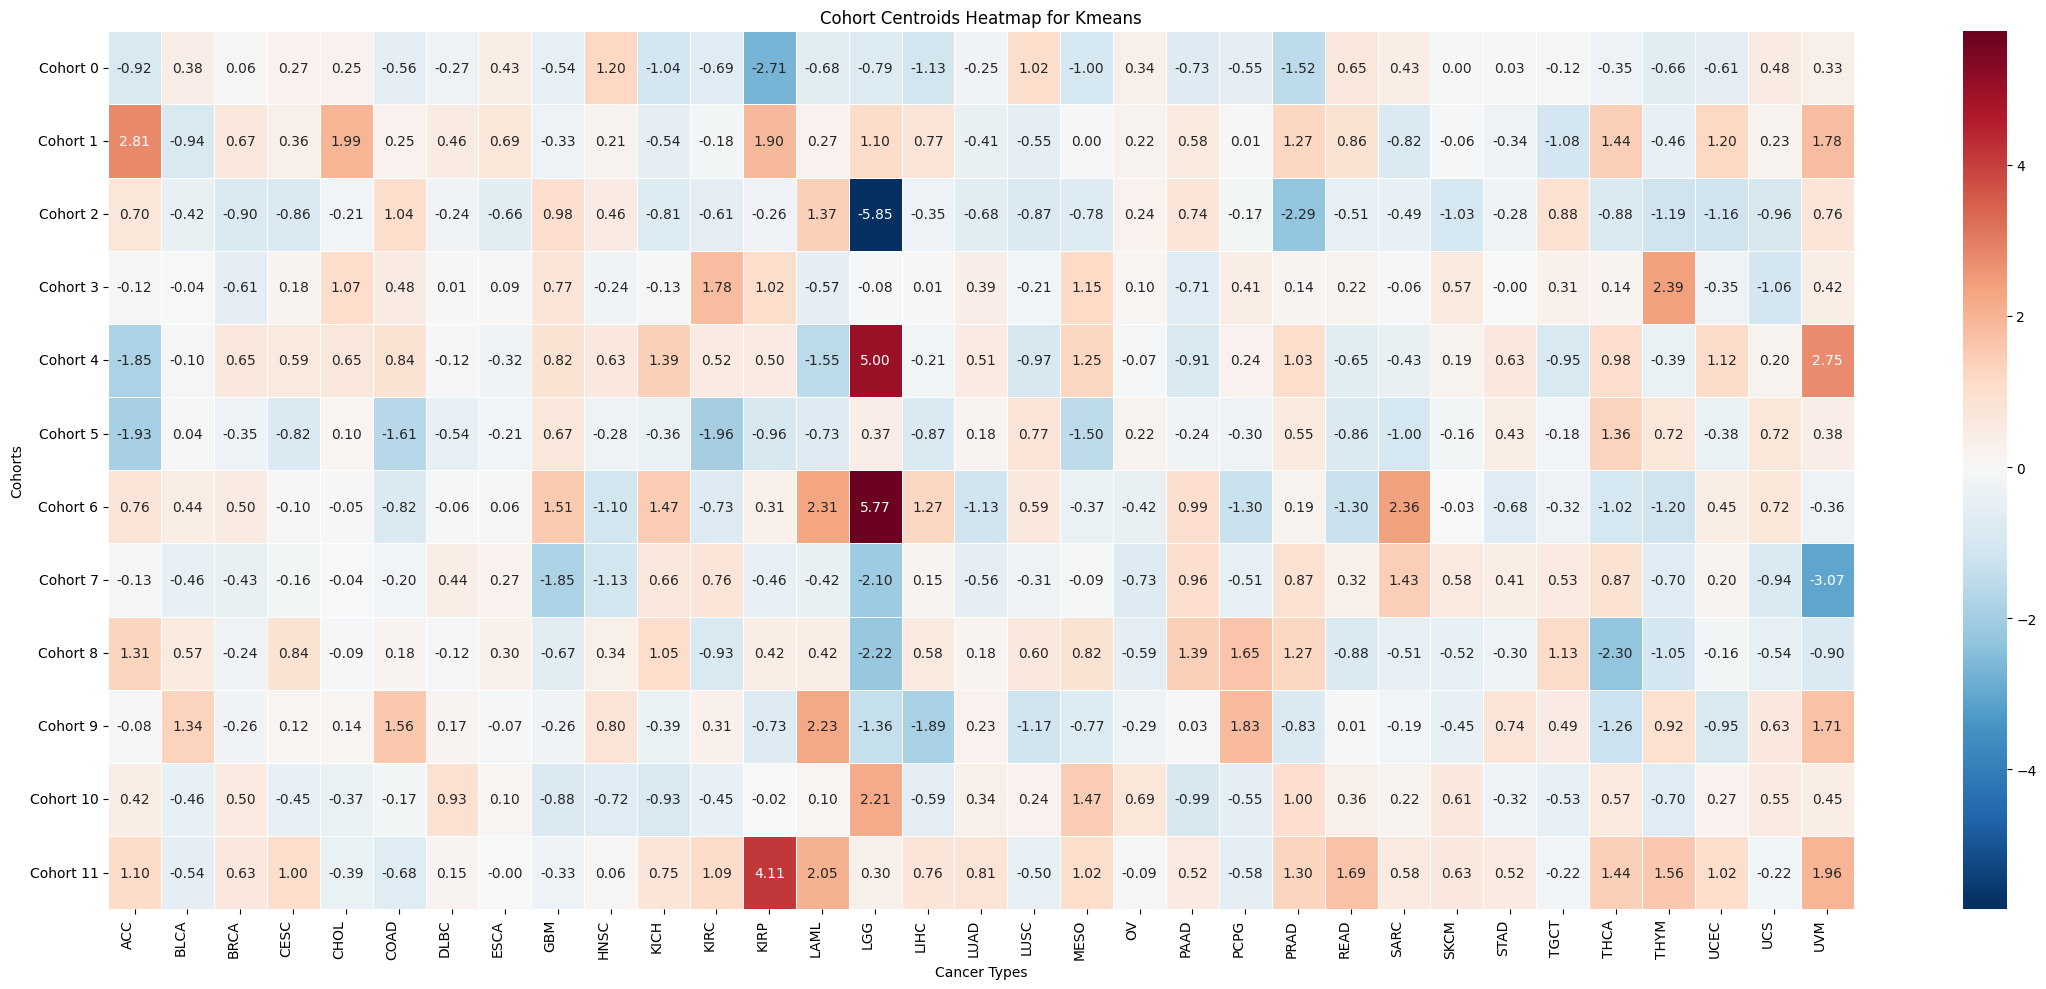

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# paths to files
csvPath = os.path.join("..", "..", "scenario", "Multivariate_CNA_filtered_by_hallmark.csv")
npyPath = "kmeans_by_feature_shap_centroids.npy"

# loading CSV for column names
dfCsv = pd.read_csv(csvPath)
print("CSV shape:", dfCsv.shape)
print("CSV columns:", dfCsv.columns.tolist())

# excluding first and last columns ('Gene' and "Stouffer's Z")
featureCols = dfCsv.columns[1:-1]
print("Number of feature columns:", len(featureCols))

# loading the centroids from .npy file
centroids = np.load(npyPath)
print("Centroids shape:", centroids.shape)

# making sure number of columns matches
if centroids.shape[1] != len(featureCols):
    raise ValueError("Number of columns in .npy does not match feature columns!")

# defining cohort labels
cohortLabels = [f"Cohort {i}" for i in range(centroids.shape[0])]

# creating the heatmap with annotations
figWidth = len(featureCols) * 0.7  
figHeight = 10 

plt.figure(figsize=(figWidth, figHeight))
sns.heatmap(
    centroids,
    xticklabels=featureCols,
    yticklabels=cohortLabels,
    cmap="RdBu_r",
    center=0,
    annot=True,          
    fmt=".2f",          
    linewidths=0.5       
)

plt.xticks(rotation=90, ha="right")
plt.ylabel("Cohorts")
plt.xlabel("Cancer Types")
plt.title("Cohort Centroids Heatmap for Kmeans")
plt.tight_layout()
plt.show()


C:\Users\Taveer Abdullah\AppData\Local\Temp\ipykernel_11604\546278653.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set1')


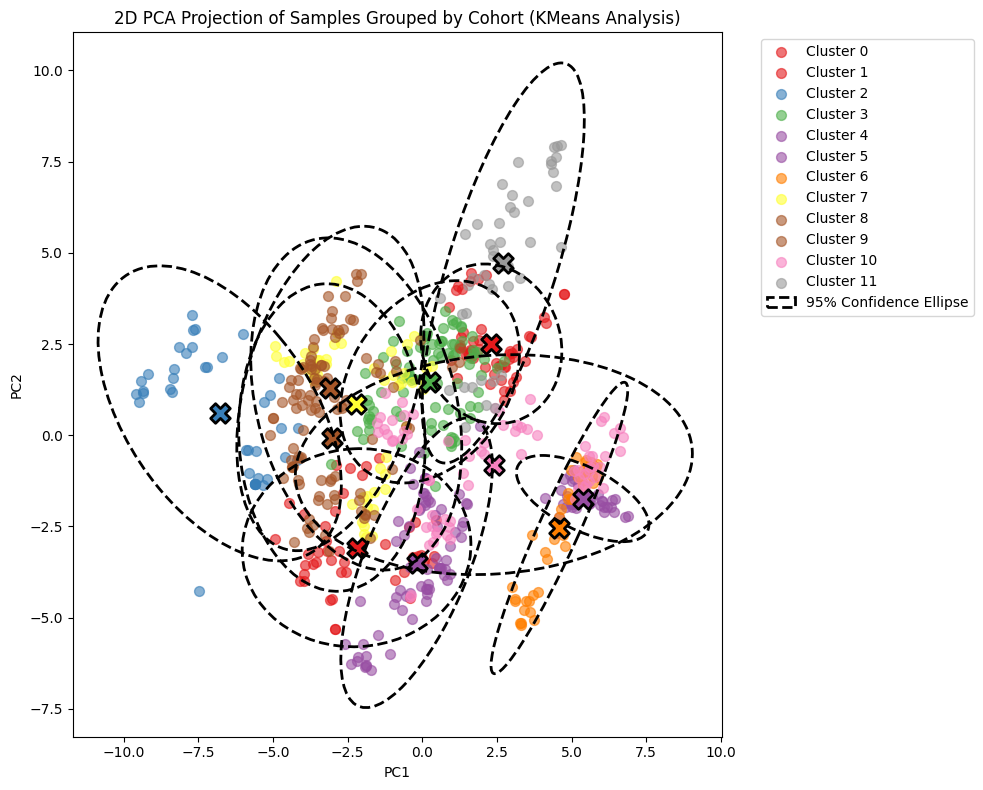

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from scipy.stats import chi2

# loading the data
labels = np.load("kmeans_by_feature_shap_labels.npy")             
centroids = np.load("kmeans_by_feature_shap_centroids.npy")       

# feature matrix
dfCsv = pd.read_csv("../../scenario/Multivariate_CNA_filtered_by_hallmark.csv")
featureCols = dfCsv.columns[1:-1]
X = dfCsv[featureCols].values

# reducing to 2D
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)
centroids2d = pca.transform(centroids)

# plotting arguments
cmap = cm.get_cmap('Set1')  
uniqueLabels = np.unique(labels)
plt.figure(figsize=(10,8))

# plotting samples
for i in uniqueLabels:
    cluster_points = X2d[labels == i]
    plt.scatter(cluster_points[:,0], cluster_points[:,1],
                color=cmap(i / len(uniqueLabels)), alpha=0.6, s=50, label=f"Cluster {i}")

# plotting centroids with same color as cluster
for i, centroid in enumerate(centroids2d):
    plt.scatter(centroid[0], centroid[1],
                color=cmap(i / len(uniqueLabels)), s=200, marker='X', edgecolor='black', linewidth=2)

# circling each cluster with 95% confidence ellipse
added_ci_label = False
for i in uniqueLabels:
    cluster_points = X2d[labels == i]
    mean = cluster_points.mean(axis=0)
    cov = np.cov(cluster_points, rowvar=False)

    # eigen-decomposition for orientation & axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # angle of ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

    # chi-square scaling factor for 95% confidence in 2D
    chi2_val = chi2.ppf(0.95, df=2)
    width, height = 2 * np.sqrt(eigvals * chi2_val)

    ellipse = Ellipse(
        mean, width, height, angle=angle,
        edgecolor='black', facecolor='none', lw=2, linestyle='--',
        label="95% Confidence Ellipse" if not added_ci_label else None
    )
    plt.gca().add_patch(ellipse)
    added_ci_label = True  

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Samples Grouped by Cohort (KMeans Analysis)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Comparative Analysis: Per-Iteration Insights

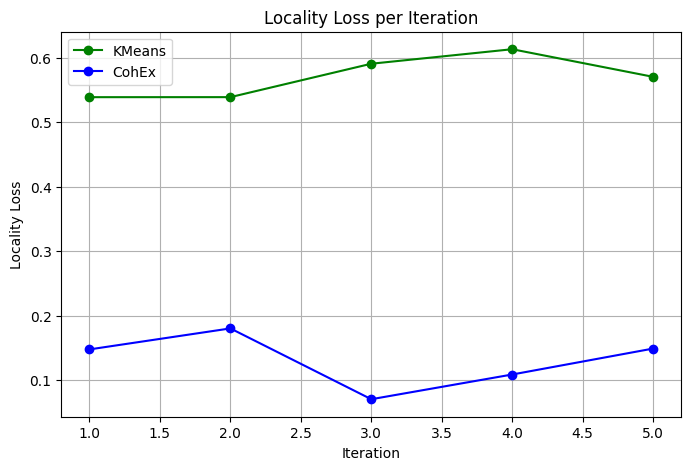

In [2]:
import matplotlib.pyplot as plt


def readLosses(filename):
    """Reads losses per iteration from the given file."""
    losses = []
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.strip().startswith("Iter"):
                value = float(line.strip().split(":")[1])
                losses.append(value)
    return losses

# reading Locality losses for Kmeans and Cohex
kmeansLosses = readLosses("kmeans_by_feature_shap_locality.txt")
cohexLosses = readLosses("cohex_shap_locality.txt")

# plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, len(kmeansLosses)+1), kmeansLosses, marker='o', color='green', label="KMeans")
plt.plot(range(1, len(cohexLosses)+1), cohexLosses, marker='o', color='blue', label="CohEx")

plt.xlabel("Iteration")
plt.ylabel("Locality Loss")
plt.title("Locality Loss per Iteration")
plt.legend()
plt.grid(True)
plt.show()


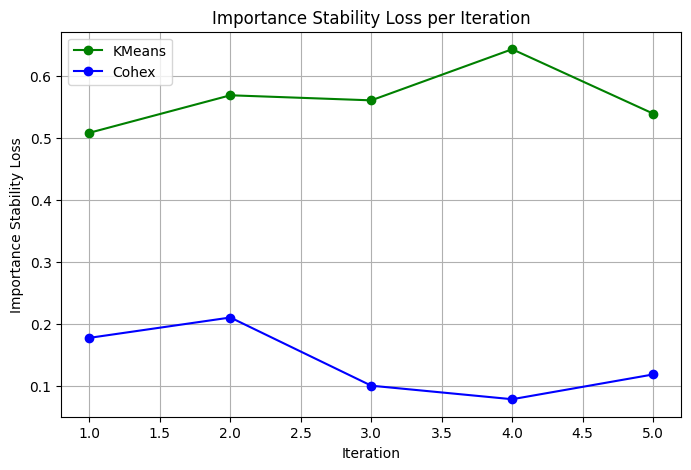

In [ ]:
import matplotlib.pyplot as plt

def read_losses(filename):
    """Reads losses per iteration from the given file."""
    losses = []
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.strip().startswith("Iter"):
                value = float(line.strip().split(":")[1])
                losses.append(value)
    return losses

# reading imporatnce stability losses for Kmeans and Cohex
kmeansLosses = read_losses("kmeans_by_feature_shap_importance_stability.txt")
cohexLosses = read_losses("cohex_shap_importance_stability.txt")

# plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, len(kmeansLosses)+1), kmeansLosses, marker='o', color='green', label="KMeans")
plt.plot(range(1, len(cohexLosses)+1), cohexLosses, marker='o', color='blue', label="CohEx")

plt.xlabel("Iteration")
plt.ylabel("Importance Stability Loss")
plt.title("Importance Stability Loss per Iteration")
plt.legend()
plt.grid(True)
plt.show()


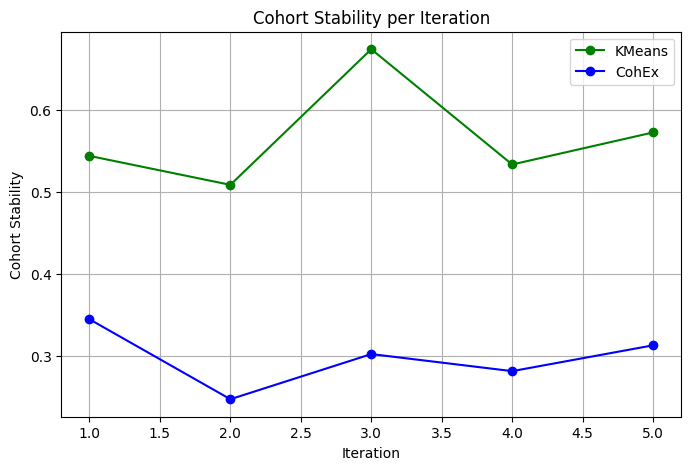

In [3]:
import matplotlib.pyplot as plt

def read_losses(filename):
    """Reads losses per iteration from the given file."""
    losses = []
    with open(filename, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.strip().startswith("Iter"):
                # Example line: "Iter 1: 0.48788313271774086"
                value = float(line.strip().split(":")[1])
                losses.append(value)
    return losses

# reading cohort stability for Kmeans and Cohex
kmeansLosses = read_losses("kmeans_by_feature_shap_cohort_stability.txt")
cohexLosses = read_losses("cohex_shap_cohort_stability.txt")

# plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, len(kmeansLosses)+1), kmeansLosses, marker='o', color='green', label="KMeans")
plt.plot(range(1, len(cohexLosses)+1), cohexLosses, marker='o', color='blue', label="CohEx")

plt.xlabel("Iteration")
plt.ylabel("Cohort Stability")
plt.title("Cohort Stability per Iteration")
plt.legend()
plt.grid(True)
plt.show()
